In [16]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [17]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [18]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc
import cmocean as cm
import glob
import numpy as np
from salishsea_tools import (
    viz_tools,
)
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import seawater as sw
import gsw

%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [19]:
SA = 35
CT = 3
p = 0

gsw.t_from_CT(SA,CT,p)

3.0025048597163271

In [20]:
reload(cs)

<module 'CCCma_stations' from '/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src/CCCma_stations.py'>

In [21]:
# help(sw.eos80)

In [22]:
def range_analyzer(start,end, prof = True, ncb = True, surfmap = True, buffmap = True, plume = True, pspace = True):
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    for i in range(0,len(arrow_array)):
        r = arrow_array[i][0]
        print(r)
        #CCCma_pipe(r, prof = prof, ncb = ncb, surfmap = surfmap, buffmap = buffmap, plume = plume, pspace = pspace)


In [23]:
def CCCma_pipe(run_date, prof = True, ncb = True, surfmap = True, buffmap = True, plume = True, pspace = True):
    #print(run_date)
    #run_date = arrow.get(date)
    ddmmmyy = run_date.format('DDMMMYY').lower()
    humandate = run_date.format('MMM DD, YYYY')
    yyyymmdd = run_date.format('YYYYMMDD')
    
    print('ANALYZING ANALYZING ',humandate)
    print('prof: ', prof, ', ncb: ', ncb, ', surfmap: ', surfmap, 'buffmap: ', buffmap,\
          ', plume: ', plume, ', pspace: ', pspace)
    #change this if you need to change strings
    
    carp1 = f'/results2/SalishSea/hindcast.201812_annex/{ddmmmyy}/SalishSea_1d_{yyyymmdd}_{yyyymmdd}_carp_T.nc'
    grid1 = f'/results2/SalishSea/hindcast.201812_annex/{ddmmmyy}/SalishSea_1d_{yyyymmdd}_{yyyymmdd}_grid_T.nc'
    carp = nc.Dataset(carp1)
    grid = nc.Dataset(grid1)
    
    rdir = '/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/hind_2018012_feb0119/'
    
    dss = days_since_start(ddmmmyy)
    print(dss)
    dss_sig = str(dss)
    
    pars_profs, stn_list, depths = profiles(carp,grid,cs.STATIONS)
    pars_pts, pt_depths, stn_list2 = point_value(carp,grid,cs.STATIONS)

    if ncb == True:
        ncmaker(stn_list, depths, pt_depths, pars_profs, pars_pts, ddmmmyy, rdir)


In [24]:
start = '2017-05-01'
end = '2017-05-02'
start_run = arrow.get(start)
end_run = arrow.get(end)
arrow_array = []
for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

for i in range(0,len(arrow_array)):
    r = arrow_array[i][0]
    run_date = r
    ddmmmyy = run_date.format('DDMMMYY').lower()
    humandate = run_date.format('MMM DD, YYYY')
    yyyymmdd = run_date.format('YYYYMMDD')
    print(ddmmmyy)

carp1 = f'/results2/SalishSea/hindcast.201812_annex/{ddmmmyy}/SalishSea_1d_{yyyymmdd}_{yyyymmdd}_carp_T.nc'
grid1 = f'/results2/SalishSea/hindcast.201812_annex/{ddmmmyy}/SalishSea_1d_{yyyymmdd}_{yyyymmdd}_grid_T.nc'
print(carp1)
carp = nc.Dataset(carp1)
grid = nc.Dataset(grid1)




01may17
02may17
/results2/SalishSea/hindcast.201812_annex/02may17/SalishSea_1d_20170502_20170502_carp_T.nc


In [25]:
print(grid.variables['votemper'])

<class 'netCDF4._netCDF4.Variable'>
float32 votemper(time_counter, deptht, y, x)
    standard_name: sea_water_conservative_temperature
    long_name: temperature
    units: degC
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 d
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered deptht nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (1, 40, 898, 398)
filling on


In [26]:
def pHOmpco2_thres(carp,grid, ddmmmyy, rdir,humandate, dss_sig,pH_M,pCO2_M,OmA_M,pH_T,pCO2_T,OmA_T):
    
    tsal = grid.variables['vosaline'][0,0,:,:]
    ttemp = grid.variables['votemper'][0,0,:,:]
    tdic = carp.variables['dissolved_inorganic_carbon'][0,0,:,:]
    tta = carp.variables['total_alkalinity'][0,0,:,:]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    tpressure[:] =1
    tzero = tpressure * 0 

    tsra_psu = tsra*35/35.16504
    
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(898,398)
    OmA = OmegaA.reshape(898,398)
    pco2R = pco2.reshape(898,398)

    #surf_dat = [tsal, tdic, tta, ttemp, pHr, OmA]
    surf_dat = [pHr, OmA, pco2R]
    print(OmA[20,250])
    print(pHr[20,250])
    print(pco2R[20,250])

    pH_20 = pH_T - pH_M
    pH_MX = pH_M + (pH_20*5)

    OmA_20 = OmA_T - OmA_M
    OmA_MX = OmA_M + (OmA_20*5)

    pCO2_20 = pCO2_T - pCO2_M
    pCO2_MX = pCO2_M + (pCO2_20*5)

    vmins = [pH_M,OmA_M,pCO2_M]
    vmaxs = [pH_MX,OmA_MX,pCO2_MX]
    msk = [1e20,1e20,1e20]
    cl = ['pH', 'Omega A', 'pCO2']
    t_cmap = [cm.cm.oxy, cm.cm.oxy, cm.cm.oxy]

    fig, ((ax1, ax2, ax3)) = \
    plt.subplots(figsize=(17, 8.5) , nrows=1, ncols=3)

    viz_tools.set_aspect(ax1)
    viz_tools.set_aspect(ax2)
    viz_tools.set_aspect(ax3)


    y1 = 0
    y2 = 898
    x1 = 0
    x2 = 398 
    i = 0
    tplt0 = surf_dat[i][y1:y2,x1:x2]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax1.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax1)
    cbar.set_label(cl[i], fontsize = 20 )
    ax1.set_xticks([])
    ax1.set_yticks([])

    i = 1
    tplt0 = surf_dat[i][y1:y2,x1:x2]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax2.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax2)
    cbar.set_label(cl[i], fontsize = 20 )
    ax2.set_xticks([])
    ax2.set_yticks([])

    i = 2
    tplt0 = surf_dat[i][y1:y2,x1:x2]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax3.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax3)
    cbar.set_label(cl[i], fontsize = 20 )
    ax3.set_xticks([])
    ax3.set_yticks([])

    st = 'pH, pCO2, Omega_A threshold plots, ' + humandate
    plt.suptitle(st,fontsize=20)    
    fname = rdir + f'{ddmmmyy}_pHT_' + dss_sig +'.png'

    #fig.savefig(fname)
    plt.show()
#plt.close()    

1e+20
1e+20
1e+20


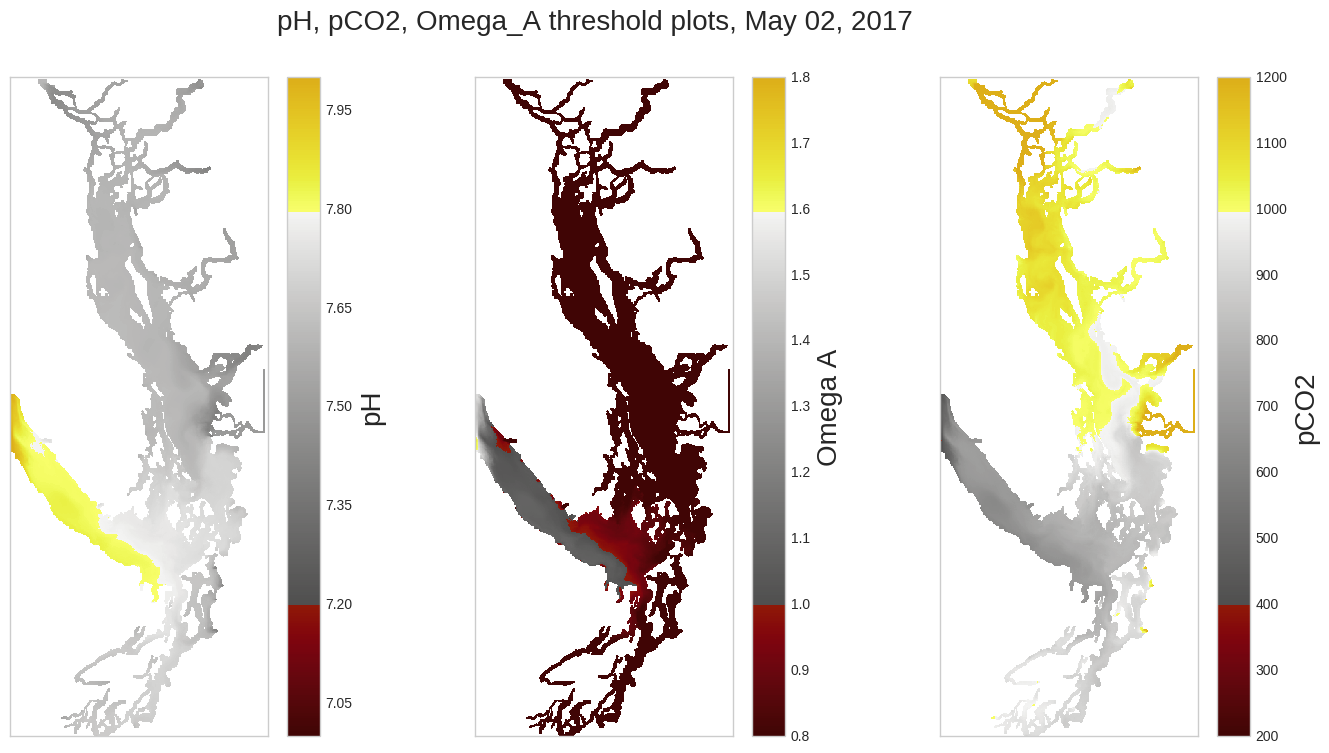

In [27]:
ddmmmyy = 'snack'
rdir = 'snack'
dss_sig = 'snack'
pH_M = 7
pH_T = 7.2
OmA_M = 0.8
OmA_T = 1
pCO2_M = 200
pCO2_T = 400
pHOmpco2_thres(carp,grid, ddmmmyy, rdir,humandate, dss_sig,pH_M,pCO2_M,OmA_M,pH_T,pCO2_T,OmA_T)